In [ ]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/HistoricalData_1731659072903.csv'
data = pd.read_csv(path)
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,11/14/2024,$311.18,120726100,$327.69,$329.98,$310.37
1,11/13/2024,$330.24,125405600,$335.85,$344.5999,$322.50
2,11/12/2024,$328.49,155726000,$342.74,$345.84,$323.31
3,11/11/2024,$350.00,210521600,$346.30,$358.64,$336.00
4,11/08/2024,$321.22,204782800,$299.14,$328.71,$297.66


In [ ]:
df = data[["Close/Last"]]
df["Close/Last"] = df["Close/Last"].str.replace('$', '', regex=False).astype(float)
df

<ipython-input-55-92e891e28f6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Close/Last"] = df["Close/Last"].str.replace('$', '', regex=False).astype(float)


,Close/Last
0,311.18
1,330.24
2,328.49
3,350.00
4,321.22
...,...
247,241.20
248,235.60
249,234.30
250,233.59


In [ ]:
dfa = pd.DataFrame(np.array(df))
dfa

,0
0,311.18
1,330.24
2,328.49
3,350.00
4,321.22
...,...
247,241.20
248,235.60
249,234.30
250,233.59


In [ ]:
scaler = MinMaxScaler()
dfs = scaler.fit_transform(dfa)

In [ ]:
#Splitting data into train and test set
train_size = int(len(dfs) * 0.8)
train_data = dfs[:train_size]
test_data = dfs[train_size:]

In [ ]:
#Split train data into train and validation set
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size]
valid_data = train_data[train_valid_size:]

In [ ]:
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_timesteps = 1
n_features = dfs.shape[1]
target_column_index = 0

In [ ]:
#Creating sequences for train, validation and test
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

In [ ]:
#Converting to tensors, as required by PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
#Creating dataloaders as the final step of converting the data to PyTorch
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/10, Train Loss: 0.024885, Valid Loss: 0.006744
Epoch 4/10, Train Loss: 0.012752, Valid Loss: 0.003521
Epoch 6/10, Train Loss: 0.005669, Valid Loss: 0.001492
Epoch 8/10, Train Loss: 0.003235, Valid Loss: 0.001000
Epoch 10/10, Train Loss: 0.002736, Valid Loss: 0.000915


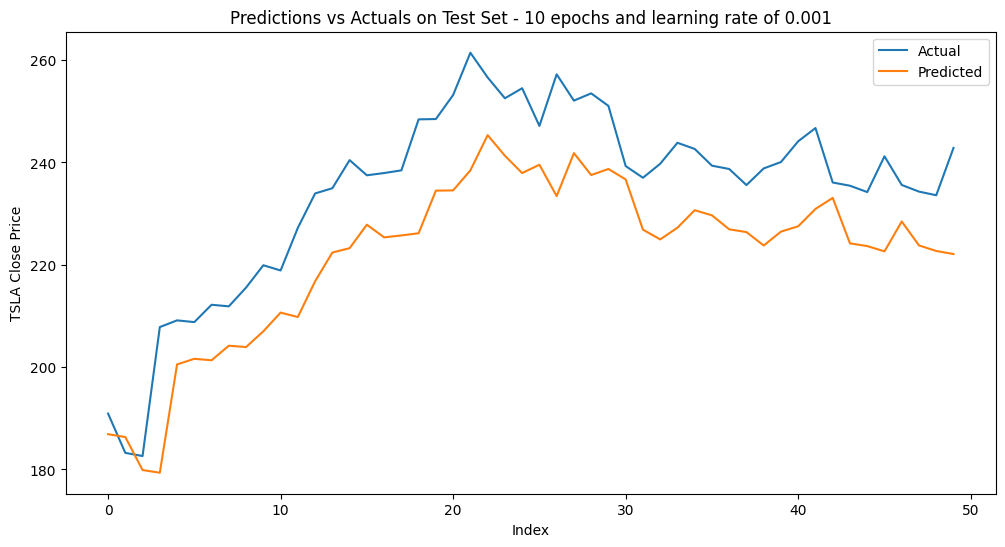

In [ ]:
#Building the RNN model with 10 epoch and learning rate of 0.001
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)

#Defining the loss function
criterion = nn.MSELoss()

#Choosing optimization approach
optimizer = optim.Adam(model.parameters())

#Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        #Forward Pass
        outputs = model(inputs)
        #Evaluation
        loss = criterion(outputs.squeeze(), targets)
        #Gradient Calculation
        loss.backward()
        #Back propagation
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

#Evaluating the Model
#Evaluating on testing set
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

#Denormalizing and Visualizing Predictions
def denormalize(dfs, scaler, index):
    data = np.zeros((len(dfs), scaler.n_features_in_))
    data[:, index] = dfs[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

#Denormalizing the predictions and actuals
test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

#Plotting predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set - 10 epochs and learning rate of 0.001')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/200, Train Loss: 0.024314, Valid Loss: 0.006751
Epoch 4/200, Train Loss: 0.013072, Valid Loss: 0.003631
Epoch 6/200, Train Loss: 0.005961, Valid Loss: 0.001556
Epoch 8/200, Train Loss: 0.003318, Valid Loss: 0.001027
Epoch 10/200, Train Loss: 0.002776, Valid Loss: 0.000931
Epoch 12/200, Train Loss: 0.002744, Valid Loss: 0.000949
Epoch 14/200, Train Loss: 0.002806, Valid Loss: 0.000990
Epoch 16/200, Train Loss: 0.002873, Valid Loss: 0.001025
Epoch 18/200, Train Loss: 0.002924, Valid Loss: 0.001051
Epoch 20/200, Train Loss: 0.002958, Valid Loss: 0.001067
Epoch 22/200, Train Loss: 0.002976, Valid Loss: 0.001074
Epoch 24/200, Train Loss: 0.002982, Valid Loss: 0.001076
Epoch 26/200, Train Loss: 0.002980, Valid Loss: 0.001074
Epoch 28/200, Train Loss: 0.002973, Valid Loss: 0.001070
Epoch 30/200, Train Loss: 0.002964, Valid Loss: 0.001064
Epoch 32/200, Train Loss: 0.002953, Valid Loss: 0.001058
Epoch 34/200, Train Loss: 0.002942, Valid Loss: 0.001051
Epoch 36/200, Train Loss: 0.002931,

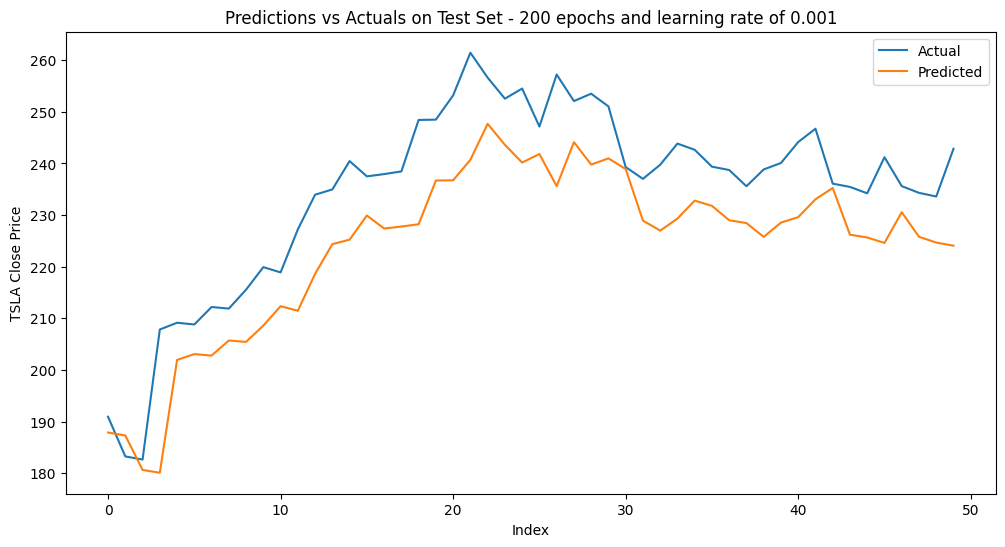

In [ ]:
#RNN model with 200 epochs and learning rate of 0.001
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)

#Defining the loss function
criterion = nn.MSELoss()

#Choosing optimization approach
optimizer = optim.Adam(model.parameters())

#Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 200
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        #Forward Pass
        outputs = model(inputs)
        #Evaluation
        loss = criterion(outputs.squeeze(), targets)
        #Gradient Calculation
        loss.backward()
        #Back propagation
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

#Evaluating the Model
#Evaluating on testing set
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

#Denormalizing and Visualizing Predictions
def denormalize(dfs, scaler, index):
    data = np.zeros((len(dfs), scaler.n_features_in_))
    data[:, index] = dfs[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

#Denormalizing the predictions and actuals
test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

#Plotting predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set - 200 epochs and learning rate of 0.001')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/200, Train Loss: 0.020273, Valid Loss: 0.005523
Epoch 4/200, Train Loss: 0.009121, Valid Loss: 0.003064
Epoch 6/200, Train Loss: 0.004422, Valid Loss: 0.001574
Epoch 8/200, Train Loss: 0.003924, Valid Loss: 0.001476
Epoch 10/200, Train Loss: 0.004099, Valid Loss: 0.001552
Epoch 12/200, Train Loss: 0.004226, Valid Loss: 0.001590
Epoch 14/200, Train Loss: 0.004268, Valid Loss: 0.001594
Epoch 16/200, Train Loss: 0.004260, Valid Loss: 0.001580
Epoch 18/200, Train Loss: 0.004225, Valid Loss: 0.001556
Epoch 20/200, Train Loss: 0.004175, Valid Loss: 0.001526
Epoch 22/200, Train Loss: 0.004120, Valid Loss: 0.001494
Epoch 24/200, Train Loss: 0.004067, Valid Loss: 0.001466
Epoch 26/200, Train Loss: 0.004021, Valid Loss: 0.001441
Epoch 28/200, Train Loss: 0.003973, Valid Loss: 0.001411
Epoch 30/200, Train Loss: 0.003923, Valid Loss: 0.001382
Epoch 32/200, Train Loss: 0.003877, Valid Loss: 0.001354
Epoch 34/200, Train Loss: 0.003833, Valid Loss: 0.001326
Epoch 36/200, Train Loss: 0.003789,

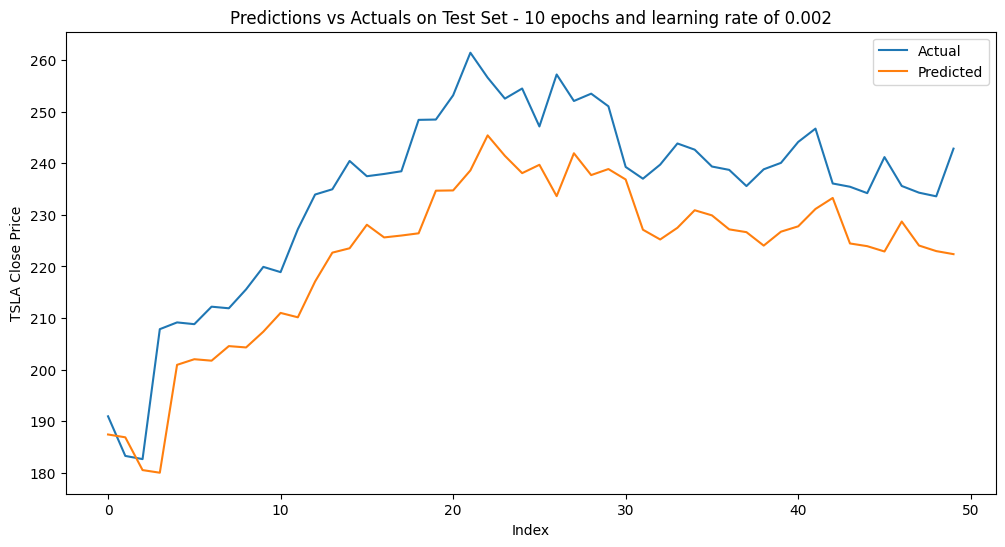

In [ ]:
#RNN Model with 200 epochs and learning rate of 0.002
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)

#Defining the loss function
criterion = nn.MSELoss()

#Choosing optimization approach
optimizer = optim.Adam(model.parameters(), lr=0.002)

#Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 200
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        #Forward Pass
        outputs = model(inputs)
        #Evaluation
        loss = criterion(outputs.squeeze(), targets)
        #Gradient Calculation
        loss.backward()
        #Back propagation
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

#Evaluating the Model
#Evaluating on testing set
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

#Denormalizing and Visualizing Predictions
def denormalize(dfs, scaler, index):
    data = np.zeros((len(dfs), scaler.n_features_in_))
    data[:, index] = dfs[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

#Denormalizing the predictions and actuals
test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

#Plotting predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set - 10 epochs and learning rate of 0.002')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()